In [1]:
!nvidia-smi

Sun Aug 27 09:06:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -U -qq gdown xmltodict kaggle #wandb clearml

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/all_AI_code/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c wheat-head-for-superai-3
!unzip -q /content/wheat-head-for-superai-3.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
100% 3.46G/3.47G [00:51<00:00, 85.6MB/s]
100% 3.47G/3.47G [00:51<00:00, 72.3MB/s]


In [6]:
import zipfile
import random
from pathlib import Path
from glob import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import json
import xmltodict

from PIL import Image, ImageDraw
import cv2

from tqdm import tqdm

In [6]:
# Load prepared images and text files in YOLO format
!cp /content/drive/MyDrive/all_AI_code/Data/dataset.zip /content/dataset.zip
!unzip -q /content/dataset.zip

In [13]:
!mv /content/content/dataset /content/

In [7]:
!git clone https://github.com/ultralytics/ultralytics
os.chdir('/content/ultralytics')
!pip -qq install -e .

Cloning into 'ultralytics'...
remote: Enumerating objects: 15141, done.
remote: Counting objects: 100% (1272/1272), done.
remote: Compressing objects: 100% (725/725), done.
remote: Total 15141 (delta 860), reused 804 (delta 547), pack-reused 13869
Receiving objects: 100% (15141/15141), 8.46 MiB | 21.18 MiB/s, done.
Resolving deltas: 100% (10337/10337), done.
  Preparing metadata (setup.py) ... done


# prepare data

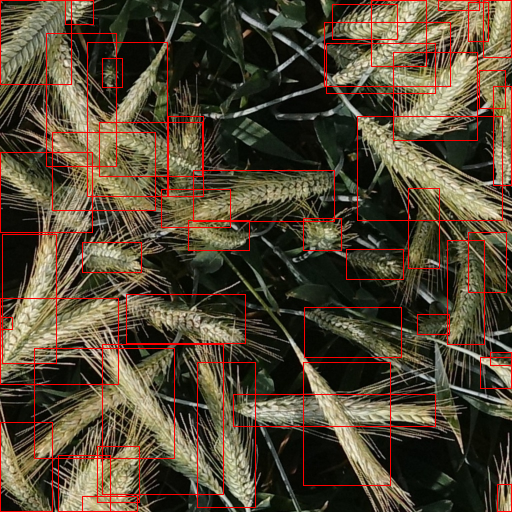

In [14]:
pth_img = '/content/Wheat-Head/train/0007634580386bd39d4d0d24df58893c3bb967e12d6fc065ce8659e9acacc928'
pth_xml = '/content/Wheat-Head/train/0007634580386bd39d4d0d24df58893c3bb967e12d6fc065ce8659e9acacc928'

img = Image.open(pth_img+'.png')
X,Y = img.size
with open(pth_xml+'.xml') as xml_file:
    data_dict = xmltodict.parse(xml_file.read())
    df = pd.DataFrame.from_dict(data_dict['annotation']['object'])[['name','bndbox']]
    df['bb'] = df.apply(lambda df : ((float(df['bndbox']['xmin']), float(df['bndbox']['ymin'])), (float(df['bndbox']['xmax']), float(df['bndbox']['ymax']))), axis=1)
    df['ymin'] = df.apply(lambda df : float(df['bndbox']['ymin']), axis=1)
    df['xmin'] = df.apply(lambda df : float(df['bndbox']['xmin']), axis=1)
    df['xmax'] = df.apply(lambda df : float(df['bndbox']['xmax']), axis=1)
    df['ymax'] = df.apply(lambda df : float(df['bndbox']['ymax']), axis=1)
    df['x_center'] = df.apply(lambda df : float((df['xmax'] + df['xmin']) / 2 / X), axis=1)
    df['y_center'] = df.apply(lambda df : float((df['ymax'] + df['ymin']) / 2 / Y), axis=1)
    df['x_ration'] = df.apply(lambda df : float((df['xmax'] - df['xmin']) / X), axis=1)
    df['y_ration'] = df.apply(lambda df : float((df['ymax'] - df['ymin']) / Y), axis=1)
# df
draw = ImageDraw.Draw(img)
for i in df['bb']:
  draw.rectangle(i, outline ="red")
img

In [15]:
# test
txt = ""
for i in df[['x_center','y_center','x_ration','y_ration']].iterrows():
  txt += f"0 {i[1]['x_center']} {i[1]['y_center']} {i[1]['x_ration']} {i[1]['y_ration']}"
  if i[0] != len(df)-1: txt +='\n'
txt

'0 0.93359375 0.0419921875 0.0390625 0.076171875\n0 0.970703125 0.0556640625 0.0546875 0.111328125\n0 0.7119140625 0.0419921875 0.126953125 0.068359375\n0 0.8955078125 0.009765625 0.080078125 0.01953125\n0 0.7783203125 0.064453125 0.107421875 0.12890625\n0 0.755859375 0.10546875 0.24609375 0.125\n0 0.7431640625 0.1328125 0.212890625 0.09765625\n0 0.9609375 0.173828125 0.05078125 0.07421875\n0 0.849609375 0.1875 0.1640625 0.171875\n0 0.98046875 0.2646484375 0.03515625 0.193359375\n0 0.8388671875 0.328125 0.283203125 0.203125\n0 0.62890625 0.45703125 0.07421875 0.0625\n0 0.7314453125 0.515625 0.111328125 0.05859375\n0 0.8271484375 0.4453125 0.060546875 0.15625\n0 0.9091796875 0.5703125 0.072265625 0.203125\n0 0.951171875 0.51171875 0.07421875 0.1171875\n0 0.845703125 0.6328125 0.0625 0.0390625\n0 0.6884765625 0.6484375 0.189453125 0.09765625\n0 0.6767578125 0.8271484375 0.169921875 0.240234375\n0 0.9677734375 0.7275390625 0.060546875 0.060546875\n0 0.9775390625 0.7001953125 0.041015625 0

In [16]:
!mkdir dataset
!mkdir dataset/images
!mkdir dataset/labels
!mkdir dataset/images/train
!mkdir dataset/labels/train
!mkdir dataset/images/val
!mkdir dataset/labels/val

!mkdir text

In [7]:
ls_train = glob('/content/Wheat-Head/train/*.png')
ls_test = glob('/content/Wheat-Head/test/*.png')
# ls_train

In [18]:
no_wheat =[]
df_data = pd.DataFrame(columns=[['pth','count']])
for path in tqdm(ls_train):
  pth = path.split('.')[0]
  img = Image.open(pth+'.png')
  X,Y = img.size
  try:
    with open(pth+'.xml') as xml_file:
        data_dict = xmltodict.parse(xml_file.read())
        df = pd.DataFrame.from_dict(data_dict['annotation']['object'])[['name','bndbox']]
        df['bb'] = df.apply(lambda df : ((float(df['bndbox']['xmin']), float(df['bndbox']['ymin'])), (float(df['bndbox']['xmax']), float(df['bndbox']['ymax']))), axis=1)
        df['ymin'] = df.apply(lambda df : float(df['bndbox']['ymin']), axis=1)
        df['xmin'] = df.apply(lambda df : float(df['bndbox']['xmin']), axis=1)
        df['xmax'] = df.apply(lambda df : float(df['bndbox']['xmax']), axis=1)
        df['ymax'] = df.apply(lambda df : float(df['bndbox']['ymax']), axis=1)
        df['x_center'] = df.apply(lambda df : float((df['xmax'] + df['xmin']) / 2 / X), axis=1)
        df['y_center'] = df.apply(lambda df : float((df['ymax'] + df['ymin']) / 2 / Y), axis=1)
        df['x_ration'] = df.apply(lambda df : float((df['xmax'] - df['xmin']) / X), axis=1)
        df['y_ration'] = df.apply(lambda df : float((df['ymax'] - df['ymin']) / Y), axis=1)
    txt = ""
    for i in df[['x_center','y_center','x_ration','y_ration']].iterrows():
      txt += f"0 {i[1]['x_center']} {i[1]['y_center']} {i[1]['x_ration']} {i[1]['y_ration']}"
      if i[0] != len(df)-1: txt +='\n'
    name = pth.split('/')[-1]
    with open(f"/content/text/{name}.txt", 'w') as f:
      f.write(f"{txt}")
    df_data.loc[len(df_data)] = [pth, len(df)]
  except:
    no_wheat.append(path)
    df_data.loc[len(df_data)] = [pth, 0]

  5%|▍         | 208/4558 [00:06<01:42, 42.38it/s]<ipython-input-18-5a5b34e4dee4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bb'] = df.apply(lambda df : ((float(df['bndbox']['xmin']), float(df['bndbox']['ymin'])), (float(df['bndbox']['xmax']), float(df['bndbox']['ymax']))), axis=1)
<ipython-input-18-5a5b34e4dee4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ymin'] = df.apply(lambda df : float(df['bndbox']['ymin']), axis=1)
 47%|████▋     | 2154/4558 [00:57<00:51, 46.24it/s]<ipython-input

No wheat : 99


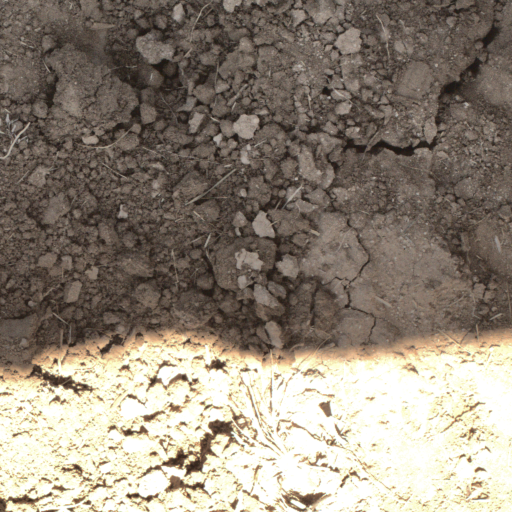

In [19]:
print('No wheat :',len(no_wheat))
path = random.choice(no_wheat)
img = Image.open(path)
img

In [20]:
# ymal file
with open(f"/content/dataset/dataset.yaml", 'w') as f:
  txt = '\
  path: /content/dataset\n\
  train: images/train\n\
  val: images/val\n\
  \n\
  names:\n\
   0: wheat\n\
   1: bg'
  f.write(f"{txt}")

### spilt train val

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_data['pth'], df_data['count'], train_size=0.9, random_state=2349009)

In [22]:
# train
for pth in tqdm(X_train['pth'].iterrows()):
  pic_name = pth[1]['pth'].split('/')[-1] + '.png'
  name = pic_name.split('.')[0]
  img_pth = pth[1]['pth']+'.png'
  text_pth = '/content/text/' + name +'.txt'
  if os.path.exists(img_pth):
    new_pth = '/content/dataset/images/train/' + pic_name
    os.popen(f'cp {img_pth} {new_pth}')
  if os.path.exists(text_pth):
    new_pth = '/content/dataset/labels/train/' + name + '.txt'
    os.popen(f'cp {text_pth} {new_pth}')
# val
for pth in tqdm(X_test['pth'].iterrows()):
  pic_name = pth[1]['pth'].split('/')[-1] + '.png'
  name = pic_name.split('.')[0]
  img_pth = pth[1]['pth']+'.png'
  text_pth = '/content/text/' + name +'.txt'
  if os.path.exists(img_pth):
    new_pth = '/content/dataset/images/val/' + pic_name
    os.popen(f'cp {img_pth} {new_pth}')
  if os.path.exists(text_pth):
    new_pth = '/content/dataset/labels/val/' + name + '.txt'
    os.popen(f'cp {text_pth} {new_pth}')

4102it [00:29, 138.04it/s]
456it [00:03, 130.51it/s]


In [23]:
df_data.to_csv('/content/dataset/data.csv', index=False)

In [ ]:
!zip -r -q /content/dataset.zip /content/dataset/
!cp /content/dataset.zip /content/drive/MyDrive/all_AI_code/Data/

# train

In [14]:
df_data = pd.read_csv('/content/dataset/data.csv')
df_data.head()

,pth,count
0,/content/Wheat-Head/train/4a223f164f5c63d04f04...,29
1,/content/Wheat-Head/train/e3f55092551f5478aac8...,20
2,/content/Wheat-Head/train/321192b355042476a45b...,56
3,/content/Wheat-Head/train/dc91c610a32305ba47be...,34
4,/content/Wheat-Head/train/6653874e7ce6da5bf7b9...,29


In [11]:
from ultralytics import RTDETR, YOLO

# model = RTDETR("rtdetr-l.pt")
model = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 79.0MB/s]


In [15]:
model.train(
    data = "/content/dataset/dataset.yaml", #
    epochs = 20,
    batch = 12, # -1 Auto Batch size
    )

Ultralytics YOLOv8.0.163 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/dataset/dataset.yaml, epochs=20, patience=50, batch=12, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=Fa

In [8]:
!cp /content/ultralytics/runs/detect/train2/weights/best.pt /content/drive/MyDrive/all_AI_code/Data/yolov8m_best.pt
!cp /content/ultralytics/runs/detect/train2/weights/last.pt /content/drive/MyDrive/all_AI_code/Data/yolov8m_ep20.pt

Test

In [15]:
model = YOLO('/content/ultralytics/runs/detect/train2/weights/best.pt')


image 1/1 /content/Wheat-Head/test/9bd45d3b9c0b7facbe1c810ec0fd3934e2754c100578b341d2e2e572dbaf1ecc.png: 640x640 35 wheats, 37.1ms
Speed: 2.7ms preprocess, 37.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


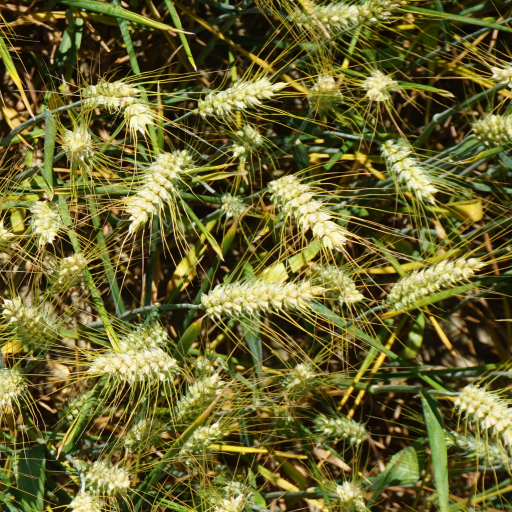

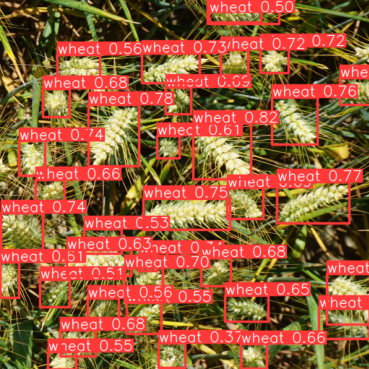

In [21]:
path = random.choice(ls_test)

pred = model.predict(path, conf=0.34,max_det=200, device='cuda')[0]
res_plotted = pred.plot()
plt.axis(False)
plt.rcParams['savefig.pad_inches'] = 0
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
img = Image.open(path)
img

In [22]:
len(pred)

35

#predict

In [29]:
model = YOLO('/content/ultralytics/runs/detect/train2/weights/best.pt')

In [30]:
df_predict = pd.read_csv('/content/Wheat-Head/sample_submission.csv')
df_predict

,ID,number
0,0391cffccc73125fe634673f775e67ade00dc122d60b50...,0
1,9cf856e540cd2b15b321b41022b0939e6ab78f8130bc80...,0
2,bf6e4feae09511784986941d2920b53a743cbef713f60d...,0
3,1145d0434ca27b4b1cab02aff453791870013986c93e38...,0
4,3776ccd9c3af4170f1e626e4e99f41a4d260e7b23deb3e...,0
...,...,...
1949,049191e969043c6cea6d744e0f2d7f67ea43ecd3a2fe25...,0
1950,c946a138291def864ab8a9df8ef3149acd87c36a6b50a4...,0
1951,f54def372bca1b6a143d1b728ed7342bed708b21282eb9...,0
1952,b65b26d98cd73b6c02a313d446c54214b1336113b0d2a3...,0


In [ ]:
for i in tqdm(range(len(df_predict))):
  img = '/content/Wheat-Head/test/'+ df_predict['ID'][i]
  result = model.predict(img, conf=0.30,max_det=200, device='cuda', show_labels= True, save=False)[0]
  df_predict.loc[i,'number'] = len(result)
  # res_plotted = result.plot()
  # plt.axis(False)
  # plt.rcParams['savefig.pad_inches'] = 0
  # plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))

In [47]:
df_predict

,ID,number
0,0391cffccc73125fe634673f775e67ade00dc122d60b50...,58
1,9cf856e540cd2b15b321b41022b0939e6ab78f8130bc80...,32
2,bf6e4feae09511784986941d2920b53a743cbef713f60d...,9
3,1145d0434ca27b4b1cab02aff453791870013986c93e38...,27
4,3776ccd9c3af4170f1e626e4e99f41a4d260e7b23deb3e...,76
...,...,...
1949,049191e969043c6cea6d744e0f2d7f67ea43ecd3a2fe25...,22
1950,c946a138291def864ab8a9df8ef3149acd87c36a6b50a4...,52
1951,f54def372bca1b6a143d1b728ed7342bed708b21282eb9...,72
1952,b65b26d98cd73b6c02a313d446c54214b1336113b0d2a3...,34


In [43]:
df_predict['number'].value_counts()

27    62
23    61
0     60
28    56
24    54
      ..
88     1
95     1
97     1
98     1
89     1
Name: number, Length: 99, dtype: int64

In [48]:
df_predict.to_csv('yolo_v8m_best_conf30.csv', index=False)

In [49]:
!kaggle competitions submit -c wheat-head-for-superai-3 -f /content/yolo_v8m_best_conf30.csv -m "yolo_v8m_best_conf30"

100% 137k/137k [00:02<00:00, 51.3kB/s]
Successfully submitted to Agricultural Product Images for SuperAI 3